In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("../code")
import plotting
import parameters_agegroups

In [66]:
C_household = np.loadtxt('../parameters/Germany_country_level_F_household_setting_85.csv', delimiter=',')
C_school = np.loadtxt('../parameters/Germany_country_level_F_school_setting_85.csv', delimiter=',')
C_workplace = np.loadtxt('../parameters/Germany_country_level_F_work_setting_85.csv', delimiter=',')
C_community = np.loadtxt('../parameters/Germany_country_level_F_community_setting_85.csv', delimiter=',')
Cs_original = np.array([C_household, C_school, C_workplace, C_community])
Cs_own = parameters_agegroups.calc_Cs()
Cs_own_rescaled = np.zeros([4,9,9])
for i in range(4):
    for n, nn in enumerate([0,0,1,1,2,2,3,4,5]):
        for m, mm in enumerate([0,0,1,1,2,2,3,4,5]):
            Cs_own_rescaled[i,n,m] = Cs_own[i,nn,mm]
vmins = np.zeros(4)
vmaxs = np.zeros(4)
for i in range(4):
#    vmins[i] = min(Cs_original[i].min(), Cs_own[i].min())
    vmaxs[i] = max(Cs_original[i].max(), Cs_own[i].max())
#vmaxs = [vmaxs.max()]*4
vmaxs = [None]*4

In [51]:
vmins

array([0., 0., 0., 0.])

NameError: name 'C_H' is not defined

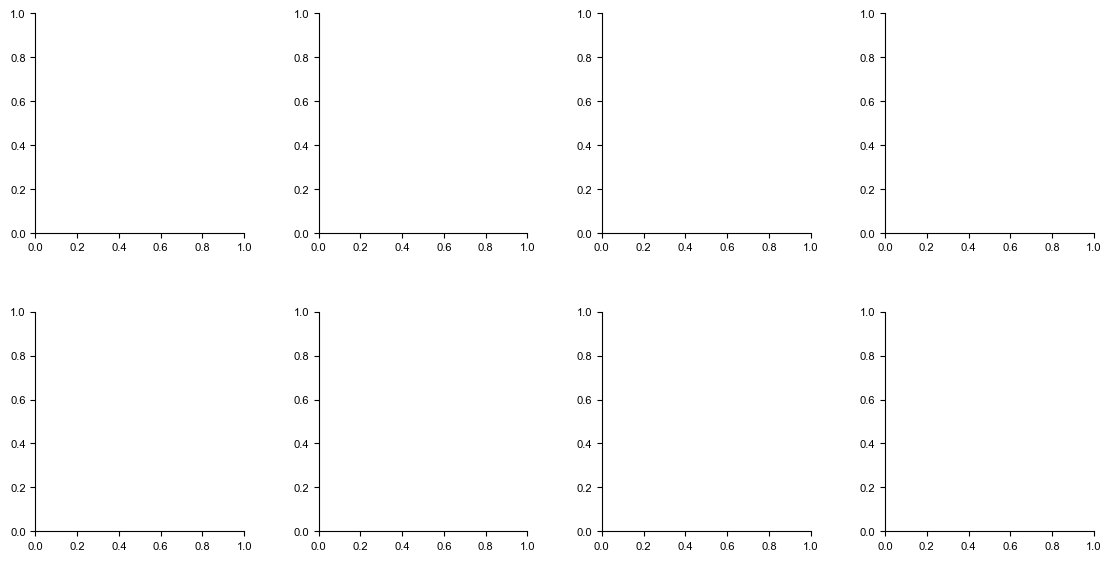

In [67]:
agegroups = ["0-19", "20-39", "40-59", "60-69","70-79", "80+"]
scenarios = ['Scenario 1', 'Scenario 2','Scenario 3','Scenario 4','Scenario 5']


data = pd.read_csv('../parameters/scenariosDefinition.csv', sep=';', header=0)


fig = plt.figure(figsize=(4*2.75,2*2.75), constrained_layout=True)
grid = fig.add_gridspec(ncols=4, nrows=2, hspace=0.2, wspace=0.15)
ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])
ax4 = fig.add_subplot(grid[3])
ax5 = fig.add_subplot(grid[4])
ax6 = fig.add_subplot(grid[5])
ax7 = fig.add_subplot(grid[6])
ax8 = fig.add_subplot(grid[7])

matrixaxes = [ax1,ax3,ax5,ax7]
scenarioaxes = [ax2,ax4,ax6,ax8]

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.titlesize"]= 14


#[C_household, C_school, C_workplace, C_community]
#[C_H, C_S, C_W, C_C]
for ax, matrix in zip(matrixaxes, [C_H, C_S, C_W, C_C]):
    ax.imshow(matrix)
    ax.figure.colorbar(ax.imshow(matrix), ax=ax, cmap="YlGn")


#Matrix labels:
labels=['Households','Schools','Workplaces','Communities']

for ax in matrixaxes:
    ax.set_xticks(np.arange(len(agegroups)))
    ax.set_yticks(np.arange(len(agegroups)))
    ax.set_xticklabels(agegroups)
    #ax.xaxis.set_ticks_position('top')
    ax.set_yticklabels(agegroups)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    
    if ax==ax1 or ax == ax5:
        ax.set_ylabel('Age of contacts')
    if ax==ax5 or ax == ax7:
        ax.set_xlabel('Age of individuals')
        
for ax, label,t in zip(matrixaxes, ['A','B','C','D'],labels):
        ax.text(-.12,1.1,label, size=14, weight='bold', color='black', transform=ax.transAxes)
        ax.set_title(t)


Hmax = 35

highvalues = ['householdlow','schoollow','workplacelow','communitylow']
lowvalues = ['householdhigh','schoolhigh','workplacehigh','communityhigh']

hline1 = np.linspace(0,Hmax,100)
hline2 = np.linspace(Hmax,1.5*Hmax,100)


colors = ['#19191b','#022b53','#054583','#0894b8', '#14c1ed']


linestyles=['-',':','-.','--','-']
linewidths = [2,2.5,3,3.5,4]
linewidths = [1,2,3,4,5]
order = [-1,-2,-3,-4,-5]

for ax, highs, lows in zip(scenarioaxes, highvalues, lowvalues):
    ax.set_ylim(0,1.1)
    ax.set_xlim(0,Hmax*1.5)
    if ax== ax6 or ax==ax8:
        ax.set_xlabel('Perceived ICU $H_R$')
    ax.axvline(Hmax,linestyle=':',color='gray')
    for i, o, c, l1, l2, scen in zip([0,1,2,3,4],order, colors,linestyles,linewidths,scenarios):
        ax.plot(hline1, (data[lows][i]-(data[lows][i]-data[highs][i])/Hmax*hline1), color=c, lw=l2, ls=l1,zorder=o)
        ax.plot(hline2, (data[highs][i]*np.ones(len(hline2))), color=c, lw=l2, ls=l1,zorder=o, label=scen)
        
ax2.legend()
    


plt.savefig('./figures/matrices_reduction.pdf')
plt.show()

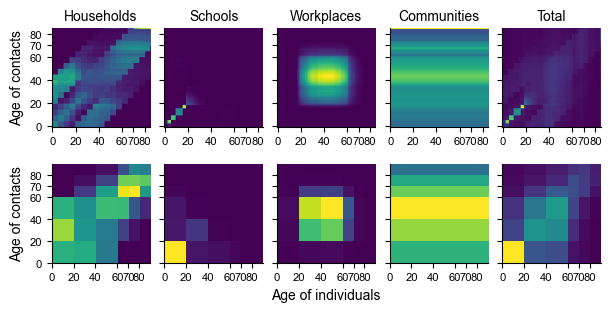

In [75]:
#agegroups = ["0-19", "20-39", "40-59", "60-69","70-79", "80+"]
#pos_agegroups = [0.5,2.5,4.5,6,7,8]
agegroups = ["0", "20", "40", "60","70", "80"]
pos_agegroups = [-0.5,1.5,3.5,5.5,6.5,7.5]
scenarios = ['Scenario 1', 'Scenario 2','Scenario 3','Scenario 4','Scenario 5']
data = pd.read_csv('../parameters/scenariosDefinition.csv', sep=';', header=0)

plotting.set_rcParams(arial=True)

fig = plt.figure(figsize=(6,3), constrained_layout=True)
grid = fig.add_gridspec(ncols=5, nrows=2, hspace=0, wspace=0)
ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(grid[2], sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(grid[3], sharex=ax1, sharey=ax1)
ax5 = fig.add_subplot(grid[4], sharex=ax1, sharey=ax1)
ax6 = fig.add_subplot(grid[5])
ax7 = fig.add_subplot(grid[6], sharex=ax6, sharey=ax6)
ax8 = fig.add_subplot(grid[7], sharex=ax6, sharey=ax6)
ax9 = fig.add_subplot(grid[8], sharex=ax6, sharey=ax6)
ax10 = fig.add_subplot(grid[9], sharex=ax6, sharey=ax6)

titles = ['Households','Schools','Workplaces','Communities','Total']

for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.imshow(Cs_original[i].transpose(), origin='lower', vmin=vmins[i], vmax=vmaxs[i])
    ax.set_title(titles[i])
ax5.imshow(Cs_original.sum(axis=0), origin='lower')
ax5.set_title(titles[4])

for i, ax in enumerate([ax6,ax7,ax8,ax9]):
    ax.imshow(Cs_own_rescaled[i].transpose(), origin='lower', vmin=vmins[i], vmax=vmaxs[i])
ax10.imshow(Cs_own_rescaled.sum(axis=0), origin='lower')

#ax1.figure.colorbar(ax1.imshow(Cs_original[0]), ax=ax1, location='bottom')

ax1.set_ylabel('Age of contacts')
ax1.set_xticks([0,20,40,60,70,80])
ax1.set_yticks([0,20,40,60,70,80])
#plt.setp(ax5.get_yticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax6.set_ylabel('Age of contacts')    
ax6.set_xticks(pos_agegroups)
ax6.set_yticks(pos_agegroups)
ax6.set_xticklabels(agegroups)
ax6.set_yticklabels(agegroups)

#for ax in [ax6,ax7,ax8,ax9,ax10]:
#    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
#    ax.set_xlabel('Age of individuals')
ax8.set_xlabel('Age of individuals')
    
for ax in [ax2,ax3,ax4,ax5,ax7,ax8,ax9,ax10]:
    plt.setp(ax.get_yticklabels(), visible=False)

#fig.align_ylabels()

plt.show()

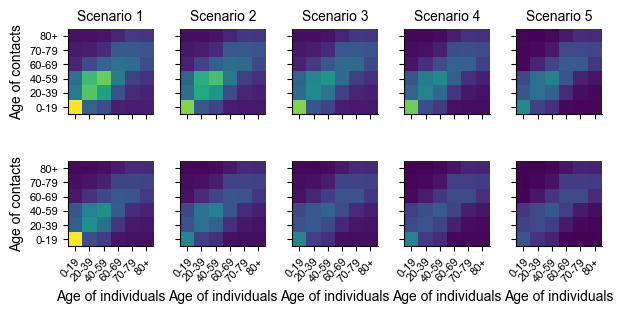

In [13]:
agegroups = ["0-19", "20-39", "40-59", "60-69","70-79", "80+"]
data = pd.read_csv('../parameters/scenariosDefinition.csv', sep=';', header=0)

plotting.set_rcParams(arial=True)

fig = plt.figure(figsize=(6,3), constrained_layout=True)
grid = fig.add_gridspec(ncols=5, nrows=2, hspace=0.2, wspace=0.15)
ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])
ax4 = fig.add_subplot(grid[3])
ax5 = fig.add_subplot(grid[4])
ax6 = fig.add_subplot(grid[5])
ax7 = fig.add_subplot(grid[6])
ax8 = fig.add_subplot(grid[7])
ax9 = fig.add_subplot(grid[8])
ax10 = fig.add_subplot(grid[9])

titles = ['Scenario 1','Scenario 2','Scenario 3','Scenario 4', 'Scenario 5']

for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
    C = (np.moveaxis(Cs_own,0,2) * parameters_agegroups.calc_ks(i+1)['k_lowH_NPI']).sum(axis=2)
    ax.imshow(C.transpose(), origin='lower', vmin=0, vmax=0.5)
#    ax.figure.colorbar(ax.imshow(matrix), ax=ax, cmap="YlGn")
    ax.set_title(titles[i])
    
    ax.set_xticks(np.arange(len(agegroups)))
    ax.set_yticks(np.arange(len(agegroups)))
    ax.set_yticklabels(agegroups)

    
for i, ax in enumerate([ax6,ax7,ax8,ax9,ax10]):
    C = (np.moveaxis(Cs_own,0,2) * parameters_agegroups.calc_ks(i+1)['k_highH_NPI']).sum(axis=2)
    ax.imshow(C.transpose(), origin='lower', vmin=0, vmax=0.5)

    ax.set_xticks(np.arange(len(agegroups)))
    ax.set_yticks(np.arange(len(agegroups)))
    ax.set_xticklabels(agegroups)
    ax.set_yticklabels(agegroups)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    ax.set_xlabel('Age of individuals')

ax1.set_ylabel('Age of contacts')
ax6.set_ylabel('Age of contacts')
        
for ax in [ax1,ax2,ax3,ax4,ax5]:
    plt.setp(ax.get_xticklabels(), visible=False)
for ax in [ax2,ax3,ax4,ax5,ax7,ax8,ax9,ax10]:
    plt.setp(ax.get_yticklabels(), visible=False)

#fig.align_ylabels()

plt.show()

In [37]:
Cs_own.shape

(4, 6, 6)

In [55]:
Cs_own[0].max()

0.13186240718700737

In [56]:
Cs_original[0].max()

0.0546604351376164

In [57]:
vmaxs[0]

0.13186240718700737